SKHASH format output


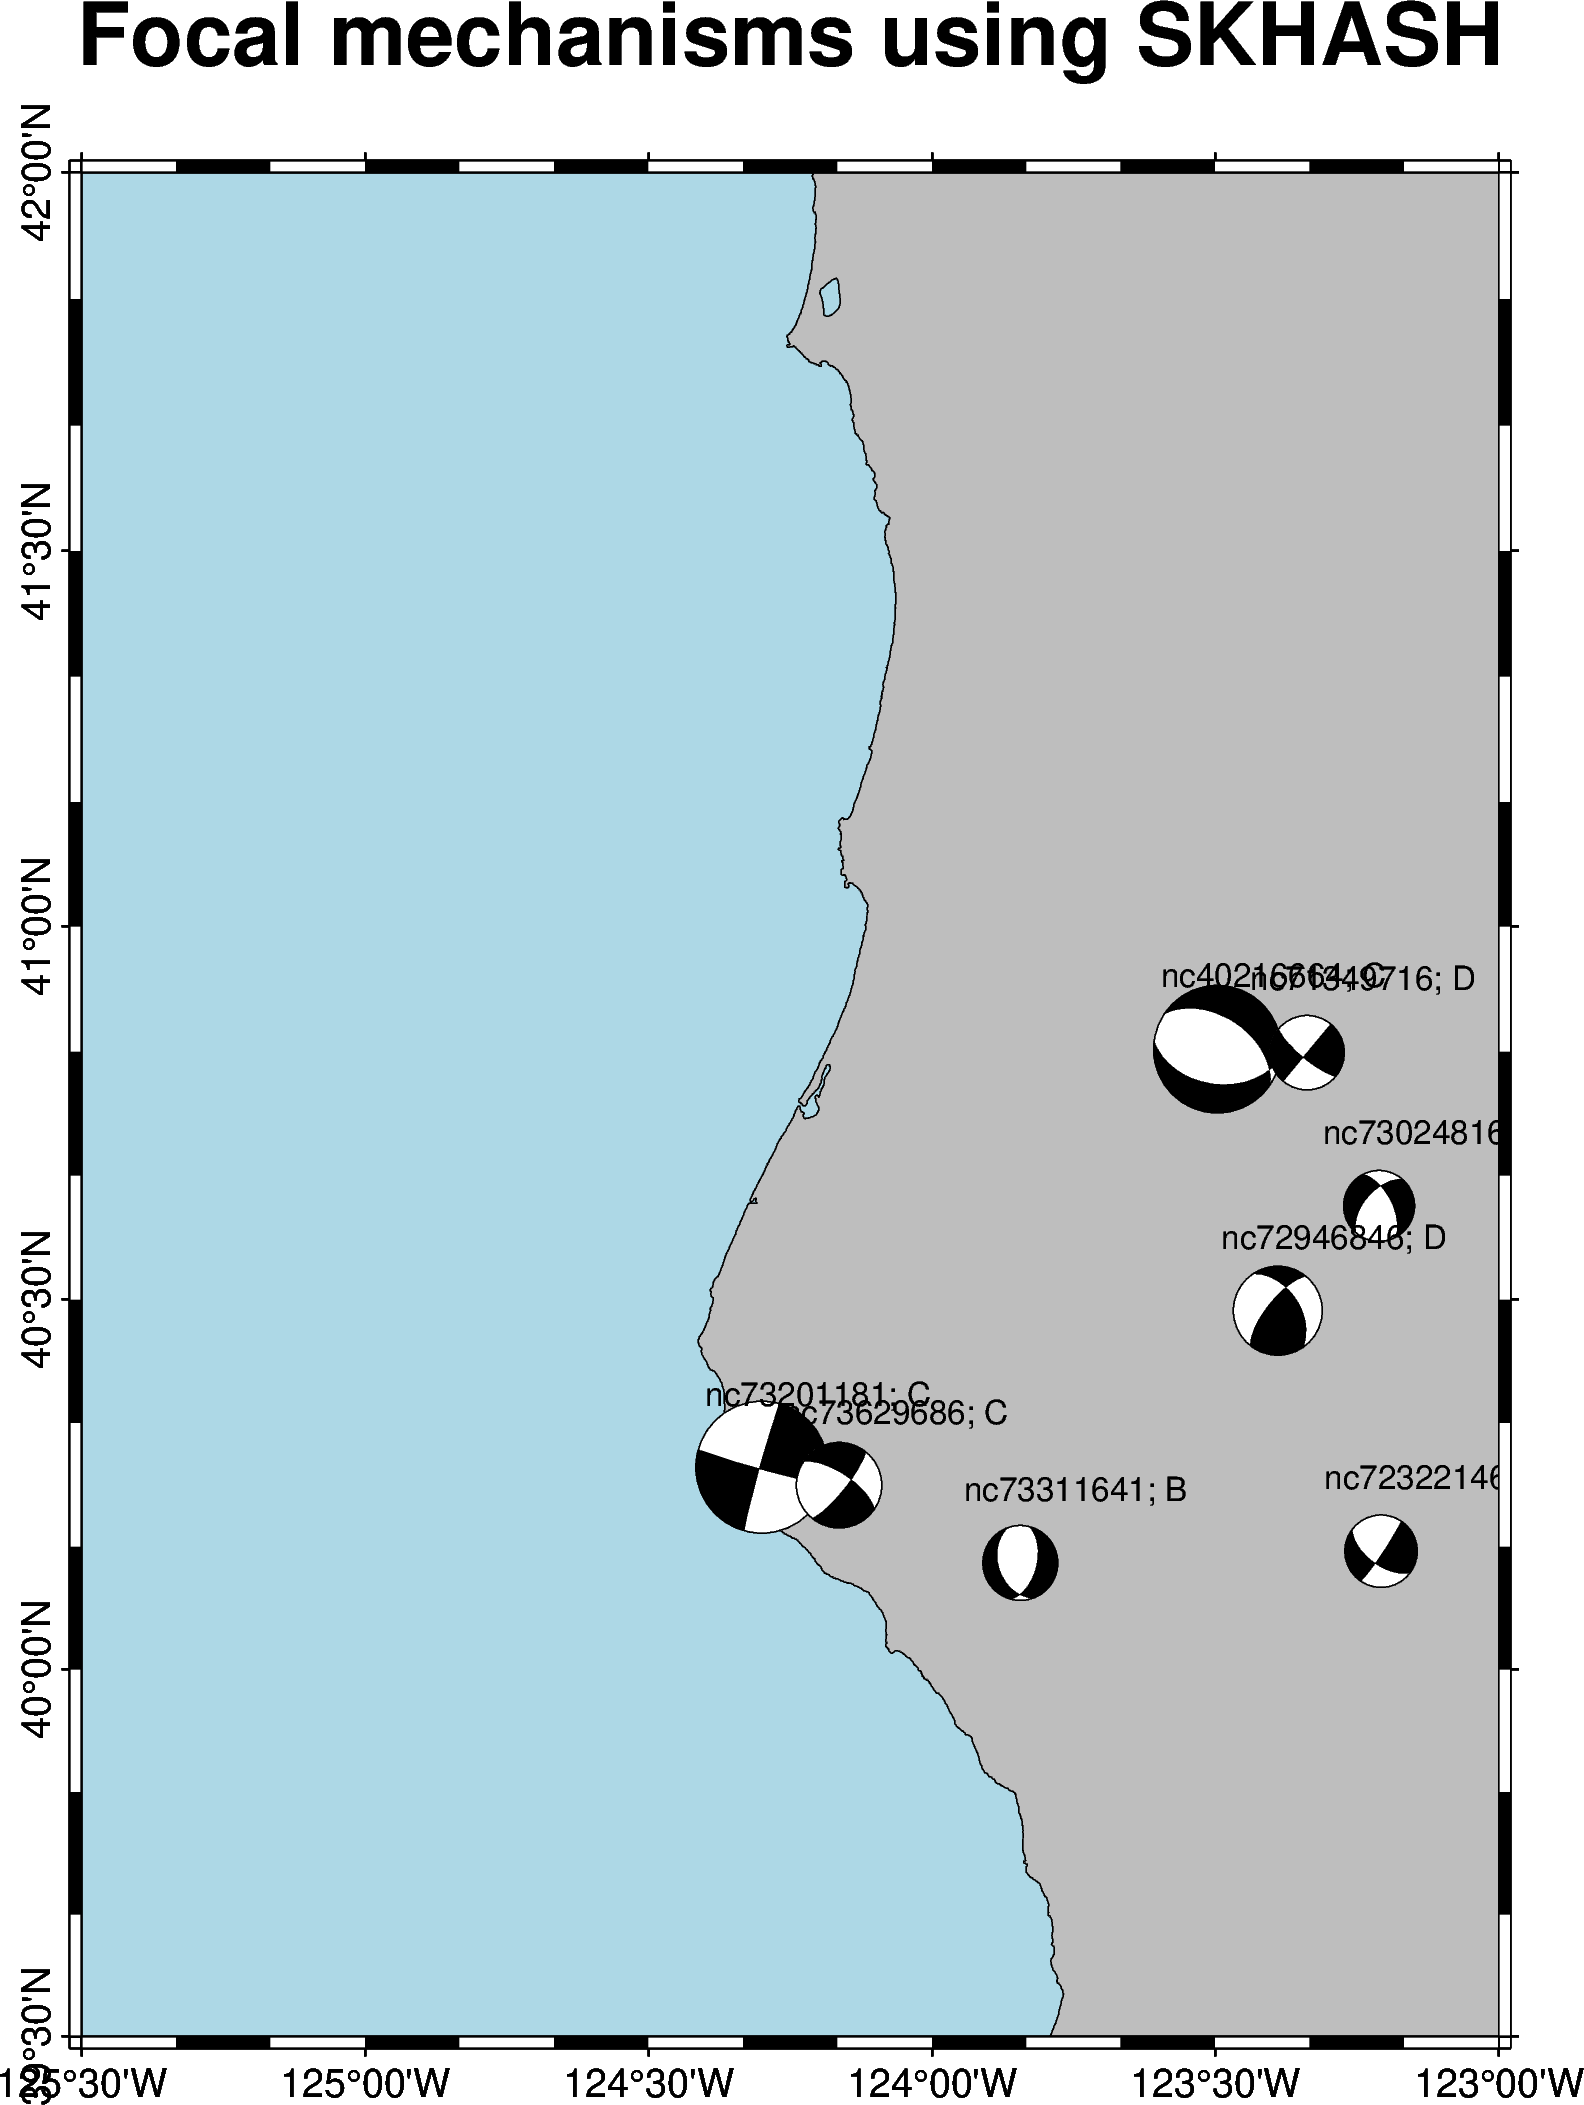

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygmt


# read the output file
focmech_path = '../data/foc_mech'

which = int(input('Which output file to plot? (1: HASH, 2: SKHASH, 3: both subplot) '))

if which == 1:
    df = pd.read_csv(f'{focmech_path}/hash_out_focmech.csv')
    df_list = [df]
elif which == 2:
    df = pd.read_csv(f'{focmech_path}/skhash_out.csv')
    df_list = [df]
elif which == 3:
    df1 = pd.read_csv(f'{focmech_path}/hash_out_focmech.csv')
    df2 = pd.read_csv(f'{focmech_path}/skhash_out.csv')
    df_list = [df1, df2]


region = [-125.5, -123, 39.5, 42]
fig = pygmt.Figure()
pygmt.config(MAP_ANNOT_OBLIQUE="lat_parallel")
fig.subplot(nrows=1, ncols=2, figsize=("30c", "10c"), sharex=True, sharey=True)

for i, idf in enumerate(df_list):
    df = idf
    # read the appropriate output file
    if df.columns[0] == 'event' and df.columns[1] == 'year':
        print('HASH format output')
        format = 'HASH'
        selected_columns = ['event', 'mag', 'elat', 'elon', 'edep', 'strike', 'dip', 'rake', 'f_qual']
        col_names = {'event': 'event_id', 'f_qual': 'quality'}
        df = df.loc[:, selected_columns]
        df = df.rename(columns=col_names)

    elif df.columns[0] == 'event_id' and df.columns[1] == 'strike':
        print('SKHASH format output')
        selected_columns = ['event_id', 'strike', 'dip', 'rake', 'quality']
        df = df[selected_columns]
        df.loc[:, ['elat', 'elon', 'edep', 'mag']] = np.nan
        # get eq location and magnitude using the event_id
        eq_df = pd.read_csv('../data/above_slab_eq_0.2_grid.csv', usecols=['latitude', 'longitude','depth','mag','id'])
        for j, row in df.iterrows():
            event_id = df['event_id'][j]
            eq_row = eq_df[eq_df['id'] == event_id]
            df.loc[j, ['elat', 'elon', 'edep', 'mag']] = eq_row[['latitude', 'longitude', 'depth', 'mag']].values[0]

    df = df.drop_duplicates(subset=['event_id'], keep='first')

    foc_mech_dict = dict(strike=df['strike'], dip=df['dip'], rake=df['rake'], magnitude=df['mag'])

    # plot basemap
    fig.set_panel(panel=i)
    fig.basemap(
        region=region,
        projection="M12c",
        frame=["WSne"] # "xaf+lLongitude", "yaf+lLatitude"],
        )
    
    # plot the coastlines, land, and water with a low resolution
    fig.coast(
        region=region,
        projection="M12c",
        land="grey",
        water="lightblue",
        shorelines=True,
        resolution="f",
        frame="a",
        
        )

    # pass the focal mechanism data to meca in addition to the scale and event location
    fig.meca(foc_mech_dict, scale="1c", longitude=df.elon, latitude=df.elat, depth=df.edep,
            )
    
    title = "Focal mechanisms using HASH" if which == 1 else "Focal mechanisms using SKHASH"

    fig.basemap(frame=["xaf+lLongitude", "yaf+lLatitude", f'+t{title}'])

    # plot location of the events with event_id,mag
    fig.text(
        x=df.elon-0.1,
        y=df.elat+0.1,
        text=df.event_id +"; " + df.quality,
        font='8p',
        justify='LM', # left middle
    )

filename = f'{focmech_path}/foc_mech_map_{"HASH" if which == 1 else "skHASH"}.png'
fig.savefig(filename, dpi=300)
fig.show()